In [28]:
import joblib
import sys
import os
from os.path import abspath
import numpy as np
from sklearn.preprocessing import StandardScaler
import h5py
import sys
import os
import pickle
import math
from os.path import abspath
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import os.path as ospath
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from scipy.signal import detrend
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit, GroupShuffleSplit
from sklearn.model_selection import train_test_split, KFold
from scipy.stats import pearsonr
import richdem as rd
from skimage import filters
from skimage.morphology import square
import gc
%matplotlib inline
if abspath('../../utils') not in sys.path:
    sys.path.append(abspath('../../utils'))
# ------------------------ 
pd.options.mode.chained_assignment = None
SITENAME = 'Tuolumne'

In [29]:
from utils import GetExtent, ventana

features = ['dem', 'vegh', 'slope', 'aspect', 'curvature']

In [30]:
import pandas as pd
import seaborn as sns
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Convolution2D, Activation
from keras import losses
from sklearn.preprocessing import StandardScaler
import gc
%matplotlib inline

In [31]:
datos = joblib.load('../../processed/subset_datos.joblib')

### Print the Shapes of the arrays found in the dictionary.

In [32]:
for llave, d in datos.items():
    print(llave, datos[llave].shape)

snowdepth (4000, 4000)
vegh (4000, 4000)
dem (4000, 4000)
slope (4000, 4000)
aspect (4000, 4000)
curvature (4000, 4000)


## Generate the X and Y for Keras

In [33]:
X = np.stack([d for llave, d in datos.items() if llave != 'snowdepth'], axis=-1)
Y = np.expand_dims(datos['snowdepth'], axis=-1)

In [34]:
print(X.shape)
print(Y.shape)

(4000, 4000, 5)
(4000, 4000, 1)


In [35]:
kernal = (50, 50)
stride = (50, 50)
XX = ventana(signal=X, kernel_size=kernal, stride=stride)
YY = ventana(signal=Y, kernel_size=kernal, stride=stride)

In [36]:
XX = np.stack(XX, axis=0)
YY = np.stack(YY, axis=0)

In [37]:
XX.shape

(6400, 50, 50, 5)

### Create Training and Testing Sets

In [38]:
Xout = {}
Yout = {}
# UTMEout = {}
# UTMNout = {}
ixs = {}
train_per = .20
# Permuter ---------------------------
train_size = np.int(np.ceil(train_per * XX.shape[0]))
permutation = np.random.permutation(XX.shape[0])
ixs['train'] = np.sort(permutation[:train_size])
ixs['test'] = np.sort(permutation[train_size:])

# Trainset ------------------------
Xout['train'] = XX[ixs['train'], :, :, :]
Yout['train'] = YY[ixs['train'], :, :, :]
# UTMEout['train'] = UTME[ixs['train'], :, :, :]
# UTMNout['train'] = UTMN[ixs['train'], :, :, :]

# Testset -------------------------
Xout['test'] = XX[ixs['test'], :, :, :]
Yout['test'] = YY[ixs['test'], :, :, :]

# UTMEout['test'] = UTME[ixs['test'], :, :, :]
# UTMNout['test'] = UTMN[ixs['test'], :, :, :]

# Scale ------------------
scaler = StandardScaler()
Xtr_tmp = scaler.fit_transform(Xout['train'].reshape(-1, XX.shape[-1]))
Xout['train'] = Xtr_tmp.reshape(Xout['train'].shape)
Xte_tmp = scaler.transform(Xout['test'].reshape(-1, XX.shape[-1]))
Xout['test'] = Xte_tmp.reshape(Xout['test'].shape)

In [39]:
print('Xtrain:', Xout['train'].shape)
print('Ytrain:', Yout['train'].shape)
print('---')
print('Xtest:', Xout['test'].shape)
print('Ytest:', Yout['test'].shape)

Xtrain: (1280, 50, 50, 5)
Ytrain: (1280, 50, 50, 1)
---
Xtest: (5120, 50, 50, 5)
Ytest: (5120, 50, 50, 1)


In [40]:
# with h5py.File("../../processed/train_test.hdf5", 'w') as f:
#     f.create_dataset('Xtrain', data=Xout['train'])
#     f.create_dataset('Xtest', data=Xout['test'])
#     f.create_dataset('Ytrain', data=Yout['train'])
#     f.create_dataset('Ytest', data=Yout['test'])
#     f.create_dataset('ixs_test', data=ixs['test'])
#     f.create_dataset('ixs_train', data=ixs['train'])

#### Define Model Architecture

In [41]:
def base_model(input_dim):
    input_layer = tf.keras.layers.Input(input_dim)
    
    conv_x = tf.keras.layers.Conv2D(filters=50, kernel_size=3, padding='same')(input_layer)
    conv_x = tf.keras.layers.SpatialDropout2D(0.25)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=50, kernel_size=3, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.25)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=50, kernel_size=3, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.25)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
        
    shortcut_x = tf.keras.layers.Conv2D(filters=50, kernel_size=1, padding='same')(input_layer)
    conv_x = tf.keras.layers.add([shortcut_x, conv_x])
    output_1 = tf.keras.layers.Activation('relu')(conv_x)
    
    conv_x = tf.keras.layers.Conv2D(filters=50, kernel_size=3, padding='same')(output_1)
    conv_x = tf.keras.layers.SpatialDropout2D(0.1)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=50, kernel_size=3, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.1)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=50, kernel_size=3, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.1)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    
    shortcut_x = tf.keras.layers.Conv2D(filters=50, kernel_size=1, padding='same')(output_1)
    conv_x = tf.keras.layers.add([shortcut_x, conv_x])
    output_2 = tf.keras.layers.Activation('relu')(conv_x)
    
    conv_x = tf.keras.layers.Conv2D(filters=100, kernel_size=3, padding='same')(output_2)
    conv_x = tf.keras.layers.SpatialDropout2D(0.25)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=100, kernel_size=3, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.25)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=100, kernel_size=3, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.25)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    
    shortcut_x = tf.keras.layers.Conv2D(filters=100, kernel_size=1, padding='same')(output_2)
    conv_x = tf.keras.layers.add([shortcut_x, conv_x])
    output_3 = tf.keras.layers.Activation('relu')(conv_x)
    
    conv_x = tf.keras.layers.Conv2D(filters=100, kernel_size=3, padding='same')(output_3)
    conv_x = tf.keras.layers.SpatialDropout2D(0.1)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=100, kernel_size=3, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.1)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
    conv_x = tf.keras.layers.Conv2D(filters=100, kernel_size=3, padding='same')(conv_x)
    conv_x = tf.keras.layers.SpatialDropout2D(0.1)(conv_x)
    conv_x = tf.keras.layers.Activation('relu')(conv_x)
        
    shortcut_x = tf.keras.layers.Conv2D(filters=100, kernel_size=1, padding='same')(output_3)
    conv_x = tf.keras.layers.add([shortcut_x, conv_x])
    output_4 = tf.keras.layers.Activation('relu')(conv_x)
    
    
    shortcut_x = tf.keras.layers.Conv2D(filters=100, kernel_size=1, padding='same')(output_3)
    conv_x = tf.keras.layers.add([shortcut_x, conv_x])
    output_4 = tf.keras.layers.Activation('relu')(conv_x)
    
    
    output_5 = tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='same')(output_4)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_5)
    
#     # UNPOOLING (unpoolB1)
#     conv_x = keras.layers.UpSampling2D()(conv_x)
    
#     # (H/2) x (W/2) x c
    
#     # DECONVOLUTION (deconvB1_1)
#     conv_x = keras.layers.Conv2DTranspose(filters=200, kernel_size=T, padding='same')(conv_x)
    
    # ---------------------------------------- #
    #            Compile Model                 #
    # ---------------------------------------- #
    model.compile(loss=tf.keras.losses.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  metrics=['mse'])
    # plot_model(
    #     model,
    #     to_file='../fire1_cnn_model_loso_{0}.png'.format(
    #         loso
    #     ),
    #     show_shapes=True
    # )
    return model


In [42]:
seed = 99
print('''
--------------------
(•_•)
<)   )╯ Train-
/   \\

(•_•)
<)   )>  ing 
/   \\ 

 \(•_•)
 (   (>  Beast
 /   \\

  (•_•)
+-)   )-+ Mode!
 /   \\
  
--------------------
''')


# ---------------------------------------- #
#         Call and Fit Model               #
# ---------------------------------------- #
# simple early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=100)

model_save = tf.keras.callbacks.ModelCheckpoint(os.path.join('../../', 'models', 'best_model.h5'),
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')

# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_r_squared', factor=0.5, patience=50, min_lr=0.0001)

# def step_decay(epoch):
#    initial_lrate = 0.0001
#    drop = 0.5
#    epochs_drop = 10.0
#    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
#    return lrate

# lrate = LearningRateScheduler(step_decay)

model = base_model(
    Xout['train'].shape[1:]
)


--------------------
(•_•)
<)   )╯ Train-
/   \

(•_•)
<)   )>  ing 
/   \ 

 \(•_•)
 (   (>  Beast
 /   \

  (•_•)
+-)   )-+ Mode!
 /   \
  
--------------------



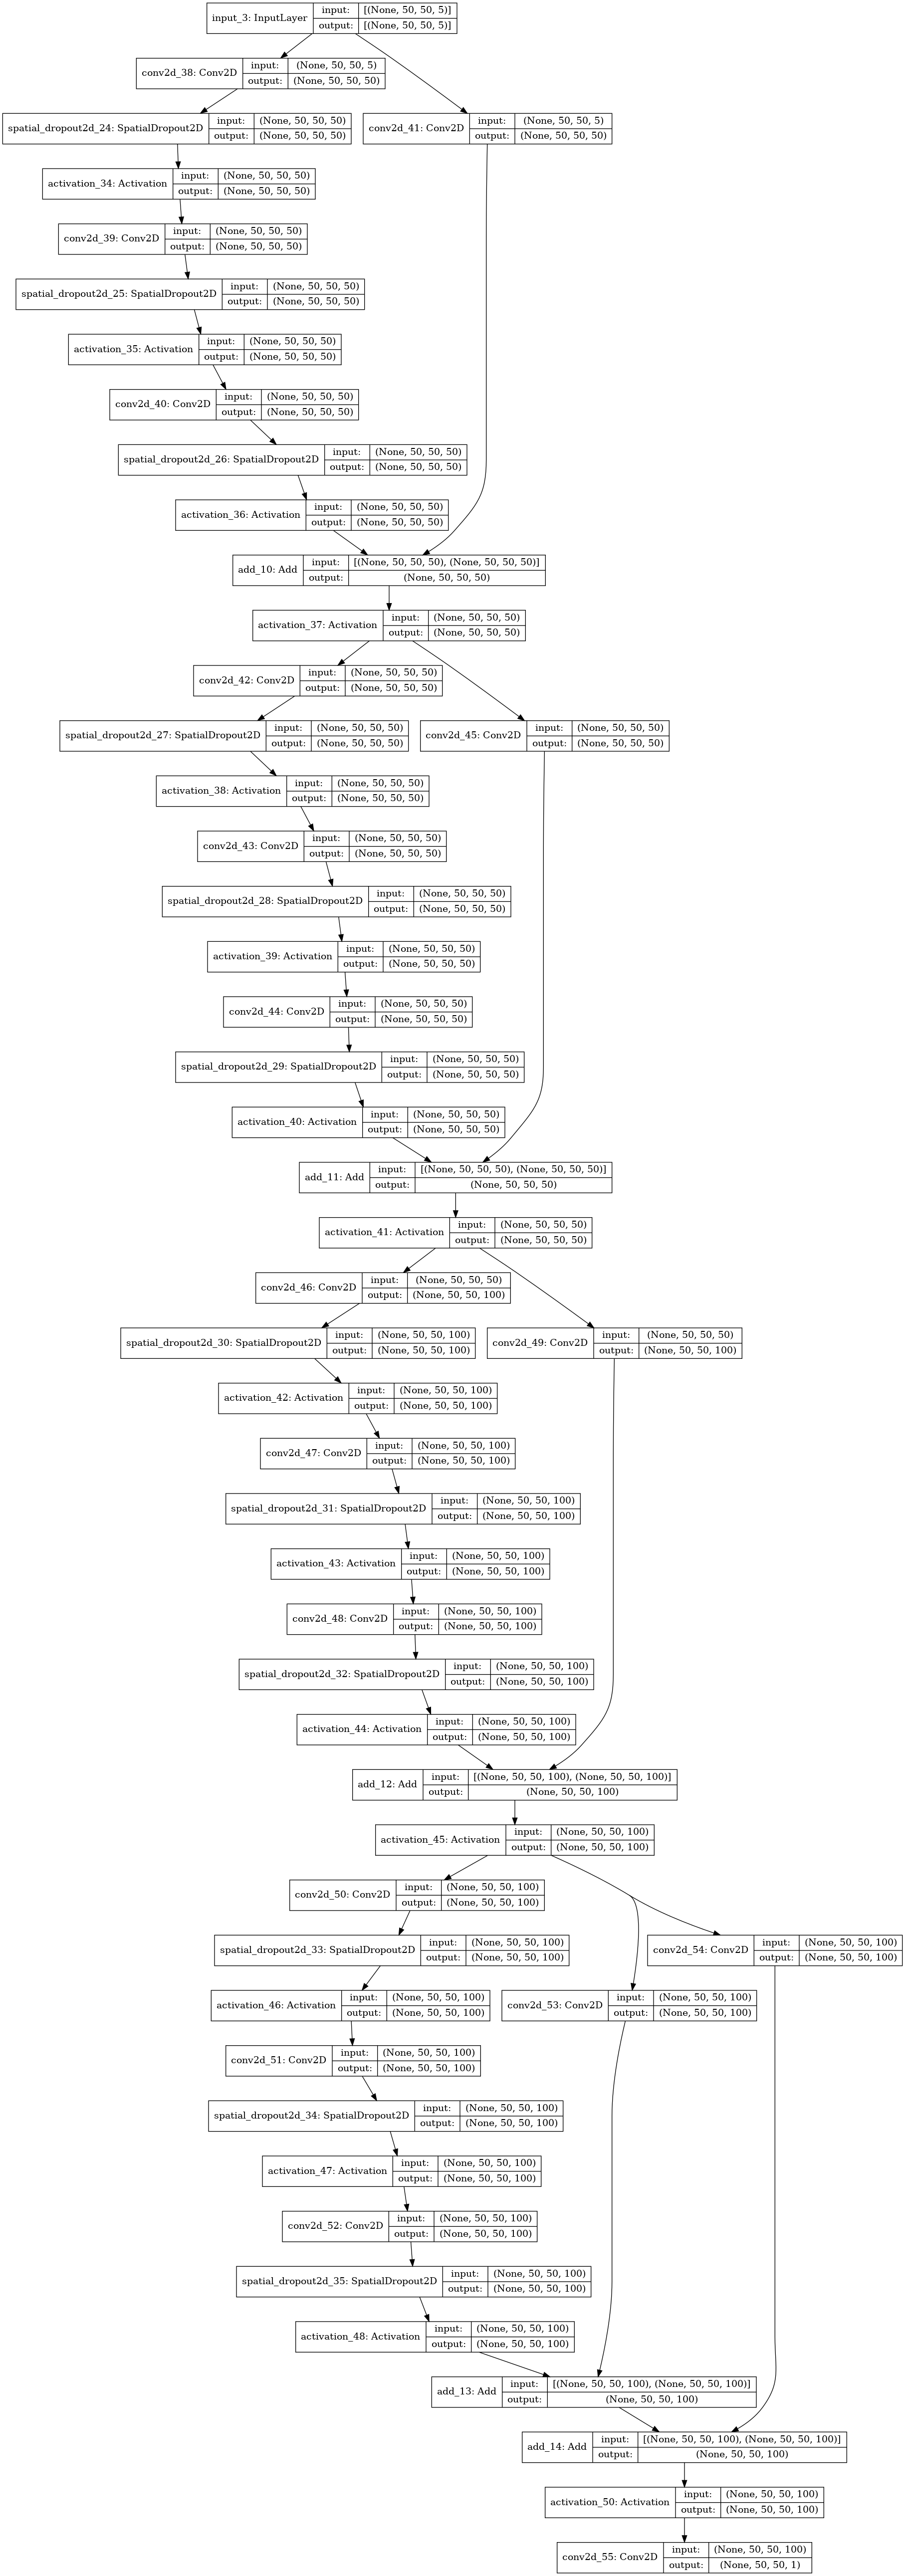

In [48]:
tf.keras.utils.plot_model(model, to_file='../../models/model_grande.png', show_shapes=True)

In [23]:
batch_size = 20
epochs=5000

#fits the model on batches with real-time data augmentation:
hist = model.fit(
    Xout['train'],
    steps_per_epoch=int(1.5 * len(Xout['train']) / batch_size),
    epochs=epochs,
    validation_data=(Xout['test'], Yout['test']),
    callbacks=[es, model_save]
)

# hist = model.fit(
#     X['train'],Y['train'],
#     epochs=epochs,
#     validation_data=(X['test'], Y['test']),
#     callbacks=[es, model_save]
# )

print('\n\n')
print('-----------------')

print('-----------------')


--------------------
(•_•)
<)   )╯ Train-
/   \

(•_•)
<)   )>  ing 
/   \ 

 \(•_•)
 (   (>  Beast
 /   \

  (•_•)
+-)   )-+ Mode!
 /   \
  
--------------------

Epoch 1/5000


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[1280,100,50,50] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_26/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[loss_1/mul/_525]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[1280,100,50,50] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_26/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

#### Simpler Model

In [24]:
def base_model(input_dim):
    model = Sequential()
    model.add(Convolution2D(
        filters=50,
        kernel_size=(10,10),
        strides=(1,1),
        padding='same',
        input_shape=input_dim)
    )
    model.add(Activation('relu'))    
    model.add(Convolution2D(
        filters=60,
        kernel_size=(10,10),
        strides=(1,1),
        padding='same')
    )
    model.add(Activation('relu'))
    model.add(Convolution2D(
        filters=70,
        kernel_size=(10,10),
        strides=(1,1),
        padding='same')
    )
    model.add(Activation('relu'))
    model.add(Convolution2D(
        filters=80,
        kernel_size=(5,5),
        strides=(1,1),
        padding='same')
    )
    model.add(Activation('relu'))
    model.add(Convolution2D(
        filters=1,
        kernel_size=(1,1),
        strides=(1,1),
        padding='same')
    )
    model.add(Activation('relu'))
    # ---------------------------------------- #
    #            Compile Model                 #
    # ---------------------------------------- #
    model.compile(loss=losses.mean_squared_error,
                  optimizer=Adam(lr=0.0001),
                  metrics=['mse'])
    return model

In [25]:
print('''
--------------------
(•_•)
<)   )╯ Train-
/   \\

(•_•)
<)   )>  ing 
/   \\ 

 \(•_•)
 (   (>  Beast
 /   \\

  (•_•)
+-)   )-+ Mode!
 /   \\
  
--------------------
''')


# ---------------------------------------- #
#         Call and Fit Model               #
# ---------------------------------------- #
# simple early stopping
es = EarlyStopping(monitor='val_mean_squared_error',
                   mode='min',
                   verbose=1,
                   patience=30)

model_save = ModelCheckpoint(os.path.join('..', 'models', 'best_model.h5'),
                             monitor='mse',
                             verbose=0,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')

model = base_model(
    Xout['train'].shape[1:]
)



hist = model.fit(
    Xout['train'], Yout['train'],
    epochs=500,
    validation_data=(Xout['test'], Yout['test']),
    batch_size=200,
    verbose=1,
    shuffle=True,
    callbacks=[es, model_save]
)
print('\n\n')
print('-----------------')

print('-----------------')

W0913 07:50:54.623780 140124344145728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0913 07:50:54.625519 140124344145728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0913 07:50:54.628528 140124344145728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0913 07:50:54.704586 140124344145728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0913 07:50:54.805608 140124344145728 deprecation_wrappe


--------------------
(•_•)
<)   )╯ Train-
/   \

(•_•)
<)   )>  ing 
/   \ 

 \(•_•)
 (   (>  Beast
 /   \

  (•_•)
+-)   )-+ Mode!
 /   \
  
--------------------



W0913 07:50:54.909704 140124344145728 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1280 samples, validate on 5120 samples
Epoch 1/500
1280/1280 [==============================] - 5s 4ms/step - loss: 0.1583 - mean_squared_error: 0.1583 - val_loss: 0.1412 - val_mean_squared_error: 0.1412
Epoch 2/500
 400/1280 [========>.....................] - ETA: 0s - loss: 0.1242 - mean_squared_error: 0.1242

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with mse available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


1280/1280 [==============================] - 1s 875us/step - loss: 0.1330 - mean_squared_error: 0.1330 - val_loss: 0.1349 - val_mean_squared_error: 0.1349
Epoch 3/500
1280/1280 [==============================] - 1s 886us/step - loss: 0.1272 - mean_squared_error: 0.1272 - val_loss: 0.1319 - val_mean_squared_error: 0.1319
Epoch 4/500
1280/1280 [==============================] - 1s 895us/step - loss: 0.1220 - mean_squared_error: 0.1220 - val_loss: 0.1259 - val_mean_squared_error: 0.1259
Epoch 5/500
1280/1280 [==============================] - 1s 883us/step - loss: 0.1185 - mean_squared_error: 0.1185 - val_loss: 0.1232 - val_mean_squared_error: 0.1232
Epoch 6/500
1280/1280 [==============================] - 1s 880us/step - loss: 0.1161 - mean_squared_error: 0.1161 - val_loss: 0.1232 - val_mean_squared_error: 0.1232
Epoch 7/500
1280/1280 [==============================] - 1s 878us/step - loss: 0.1151 - mean_squared_error: 0.1151 - val_loss: 0.1205 - val_mean_squared_error: 0.1205
Epoch 8/50

In [26]:
# ------------------ #
# Save Model Weights #
# ------------------ #

model.save_weights('../../models/model_chico_weights.h5')
# Save the model architecture
with open('../../models/model_chico_architecture.json', 'w') as f:
    f.write(model.to_json())

In [27]:
Ycal = {}
Ycal['test'] = model.predict(Xout['test']).flatten()
Ycal['test'][Ycal['test'] < 0] = 0
Ycal['train'] = model.predict(Xout['train']).flatten()
Ycal['train'][Ycal['train'] < 0] = 0


In [32]:
plot_lims = [np.array([Ycal['test'].min(), Ycal['train'].min(), Yout['train'].min(), Yout['test'].min()]).min(),
            np.array([Ycal['test'].max(), Ycal['train'].max(), Yout['train'].max(), Yout['test'].max()]).max()]

In [33]:
import matplotlib.pyplot as plt
# plt.style.use(
#     abspath('../plotstyles/fancy_figure_small_font.mplstyle')
# )



fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))

# Subplot 1 ----------------
ax1.plot(
    Yout['train'].flatten(),
    Ycal['train'].flatten(),
    '.'
)
ax1.set_aspect('equal')
ax1.title.set_text('Train Set')
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.ylim(plot_lims)
plt.xlim(plot_lims)

# Subplot 2 ----------------
ax2.plot(
    Yout['test'].flatten(),
    Ycal['test'].flatten(),
    '.'
)
ax2.title.set_text('Hold Out Set')
ax2.set_aspect('equal')
plt.subplots_adjust(wspace=1, hspace=0.15)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.ylim(plot_lims)
plt.xlim(plot_lims)

# Rsquared Values ----------------
plt.savefig('../figures/{0}_obs_vs_pred.png'.format(SITENAME))

In [28]:
print('Train R^2: {0:0.4f}'.format(metrics.r2_score(Yout['train'].flatten(), Ycal['train'].flatten())))
print('Test R^2: {0:.4f}\n'.format(metrics.r2_score(Yout['test'].flatten(), Ycal['test'].flatten())))
# Pearson Correlations -----------------
print('----------------------')
print('Train PearsonCorr: {0:0.2f}'.format(pearsonr(Yout['train'].flatten(), Ycal['train'].flatten())[0]))
print('Test PearsonCorr: {0:.2f}\n'.format(pearsonr(Yout['test'].flatten(), Ycal['test'].flatten())[0]))
print('----------------------')
print(
    'Train RMSE: {0:0.2f}'.format(
        np.sqrt(
            metrics.mean_squared_error(
                Ycal['train'].flatten(), Yout['train'].flatten()
            )
        )
    )
)
print(
    'Test RMSE: {0:.2f}\n'.format(
        np.sqrt(
            metrics.mean_squared_error(
                Ycal['test'].flatten(), Yout['test'].flatten()
            )
        )
    )
)

Train R^2: 0.3352
Test R^2: 0.2748

----------------------
Train PearsonCorr: 0.58
Test PearsonCorr: 0.53

----------------------
Train RMSE: 0.32
Test RMSE: 0.34

